In [1]:
from pathlib import Path

import kete
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS

import skyloc as sloc

In [2]:
# Download the orbit information file from JPL SBDB
# ~ 4-10min for the first time, ~10s for subsequent runs.
orb, m_ng = sloc.fetch_orb(
    output="orb_sbdb.parq",
    update_output=999,  # days - if output's last-modified is older than this, it will be updated
    filters=[
        # ("kind", "not in", ("au")),
        # ("kind", "in", ("cu", "cn")),
        ("condition_code", "in", ["0", "1"]),
    ]
)
print("Number of objects, number of columns: ", orb.shape)
print("latest 'soln_date' [US/Pacific]     : ", orb["soln_date"].max())

# Just for printing purposes...
n_ng = np.sum(m_ng)

print("Number of     grav objects          : ", orb.shape[0] - n_ng)
print("Number of non-grav objects          : ", n_ng)

Number of objects, number of columns:  (1189570, 36)
latest 'soln_date' [US/Pacific]     :  2025-06-09 07:42:01
Number of     grav objects          :  1188905
Number of non-grav objects          :  665


In [3]:
observatory = (37.071667, 240.58861, 1.400)  # lat, lon in deg, height in km

# Say your FITS files are here:
fitspaths = list(Path("testdata").glob("*.fits"))

hdus = {}
wcss = {}
fovs = []
for fpath in fitspaths:
    hdul = fits.open(fpath)
    hdu = hdul[0]
    hdus[fpath.stem] = hdu # Say you save the data HDU only

    # This FITS has JD at the *end* of the exposure, so we need to adjust it:
    jd_mid = hdu.header["JD"] - float(hdu.header["EXPTIME"]) / 86400 / 2
    wcs = WCS(hdu.header)
    wcss[fpath.stem] = wcs

    # Convert to kete-understandable observer state vector
    observer = kete.spice.earth_pos_to_ecliptic(
        jd_mid, *observatory, name=fpath.stem
    )
    # Since "earth_pos_to_ecliptic" returns proper Sun-centered observer,
    # there is no need to use sloc.fov.make_rect_fov.
    # That function will be useful when you specify an observer that is not
    # Sun-centered. Thus, just use kete's RectangleFOV.from_wcs:

    fovs.append(kete.fov.RectangleFOV.from_wcs(wcs, observer))

# some convenience for FOVs...
fovs = sloc.FOVCollection(fovs)
fovs

FOVCollection with 1 FOVs

-----
## Example usage of FOVCollection

In [4]:
# FOVCollection will be very convenient when working with a lot of FOVs.

# You can access by:
_fov = fovs[0]
# or
_fov = fovs["oph_003_20250715061809_wcs"]

# also
fovs.fov_desigs, fovs.fov_jds
# Also save as fovs.save("test.bin") and load with fovs = FOVs.load("test.bin")

# mask by filenames:
filenames = [
    "oph_003_20250715061809_wcs",
    "oph_004_20250715061809_wcs",
    "oph_005_20250715061809_wcs",
]
fovs.mask_by_desig(filenames)
# you can use fovs[fovs.mask_by_desig(filenames)]

array([ True])

-----

In [5]:
# === 1.2M objs: ~30s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)]
# Initialize
sl1 = sloc.SSOLocator(fovs=fovs, orb=orb, non_gravs=True)
#                                        ^^^^^^^^^^^^^^^
# Automatically use non-gravitational accelerations if parameters are available

# N-body propagate to mean JD of FOVs
# (later N-body simulations will be done *from* this JD0)
sl1.propagate_n_body(include_asteroids=False, jd0=np.mean)

# If you want, propag

# Check which FOVs contain which objects. dt_limit: 3 days (i.e., simple
# interpolation is used within 3 days and skips full N-body propagation)
sl1.fov_state_check(include_asteroids=False, dt_limit=3.)

fovc_hasobj1 = sloc.FOVCollection(sl1.fovc[sl1.fov_mask_hasobj])
orb_infov1 = sl1.orb.loc[sl1.orb_infov_mask].copy()

print(f"Number of FOVs with objects: {fovc_hasobj1.shape[0]} out of {len(fovs)}")
print(f"Number of objects in FOVs  : {orb_infov1.shape[0]}")

Number of FOVs with objects: 1 out of 1
Number of objects in FOVs  : 137


-----
## If you need more accuracy
In case you need something like ~arcsec-level accuracy, run a second round

In [6]:
sl2 = sloc.SSOLocator(
    fovs=fovc_hasobj1,
    orb=orb_infov1,
    non_gravs=True
)
# on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)]
# ~100k objects in orb & 1500 FOVs. (states retrieved ~20 days after jd0)
sl2.propagate_n_body(include_asteroids=True, jd0=np.mean)  # ~ 1s only
sl2.fov_state_check(include_asteroids=True, dt_limit=0.1)  # ~10s for dt_limit=0.5, 15s for 0.25, 25s for 0.1
sl2.calc_ephems()  # ~ 10s for ~800k rows
# If you want the exact values in ephemeris, you can run:
# sl2.calc_ephems(dtypes=None)
# Default dtypes are here: print(sloc.core._EPH_DTYPES)

fovc_hasobj2 = sloc.FOVCollection(sl2.fovc[sl2.fov_mask_hasobj])
orb_infov2 = sl2.orb.loc[sl2.orb_infov_mask].copy()

-----

In [7]:
eph = sl2.eph
eph = eph.loc[eph["vmag"] < 20].copy()
eph
# Save nightly ephemeris to a file by, e.g.,
# eph.to_parquet("eph_<DATE>_{orb['soln_date'].max()}.parq", index=False)

,desig,alpha,r_hel,r_obs,ra,dec,hel_ecl_lon,hel_ecl_lat,obs_ecl_lon,obs_ecl_lat,dra*cosdec/dt,ddec/dt,sky_motion,sky_motion_pa,vmag,obsindex
0,17006,19.912743,2.111094,1.266470,253.621739,-0.520766,270.969028,12.942826,252.305914,21.918111,-0.145353,-0.264841,0.302106,-151.240631,15.856264,0
1,5280,19.778067,2.102829,1.252984,253.928610,-1.167619,271.258805,12.510030,252.716777,21.312580,-0.096851,-0.215985,0.236706,-155.847778,16.312231,0
2,7889,24.702240,1.691054,0.805780,255.413078,0.533848,276.532475,10.809762,254.101388,23.171658,-0.992619,-1.510820,1.807725,-146.694794,16.385752,0
3,15356,17.496674,2.377973,1.545491,253.893322,-0.698369,269.085541,13.953075,252.619320,21.774341,-0.265575,-0.357213,0.445119,-143.370529,16.777435,0
4,18955,14.714640,2.731988,1.899729,255.926112,-0.513819,268.477340,15.224325,254.775407,22.184718,-0.249765,-0.106083,0.271360,-113.012390,17.225021,0
5,46576,16.648102,2.469843,1.636653,254.519338,-0.780027,268.925221,14.226900,253.299012,21.766214,-0.249582,-0.300540,0.390661,-140.292236,17.640898,0
6,8168,14.327224,2.840245,2.017675,256.049423,0.963379,268.011397,16.570370,254.740823,23.666712,-0.344069,-0.076861,0.352549,-102.592552,17.844805,0
7,33647,17.059881,2.358619,1.510327,255.647203,-1.263593,270.439482,13.520114,254.561663,21.409770,-0.215149,-0.199360,0.293315,-132.818619,17.942818,0
8,40096,14.531976,2.801069,1.977223,255.423939,-0.013171,267.752847,15.761275,254.177664,22.629061,-0.266893,-0.310134,0.409163,-139.285614,18.033504,0
9,121225,16.137678,2.535639,1.703341,255.800562,0.857489,269.392890,15.561787,254.482996,23.535145,-0.261458,-0.111257,0.284145,-113.050896,18.186916,0


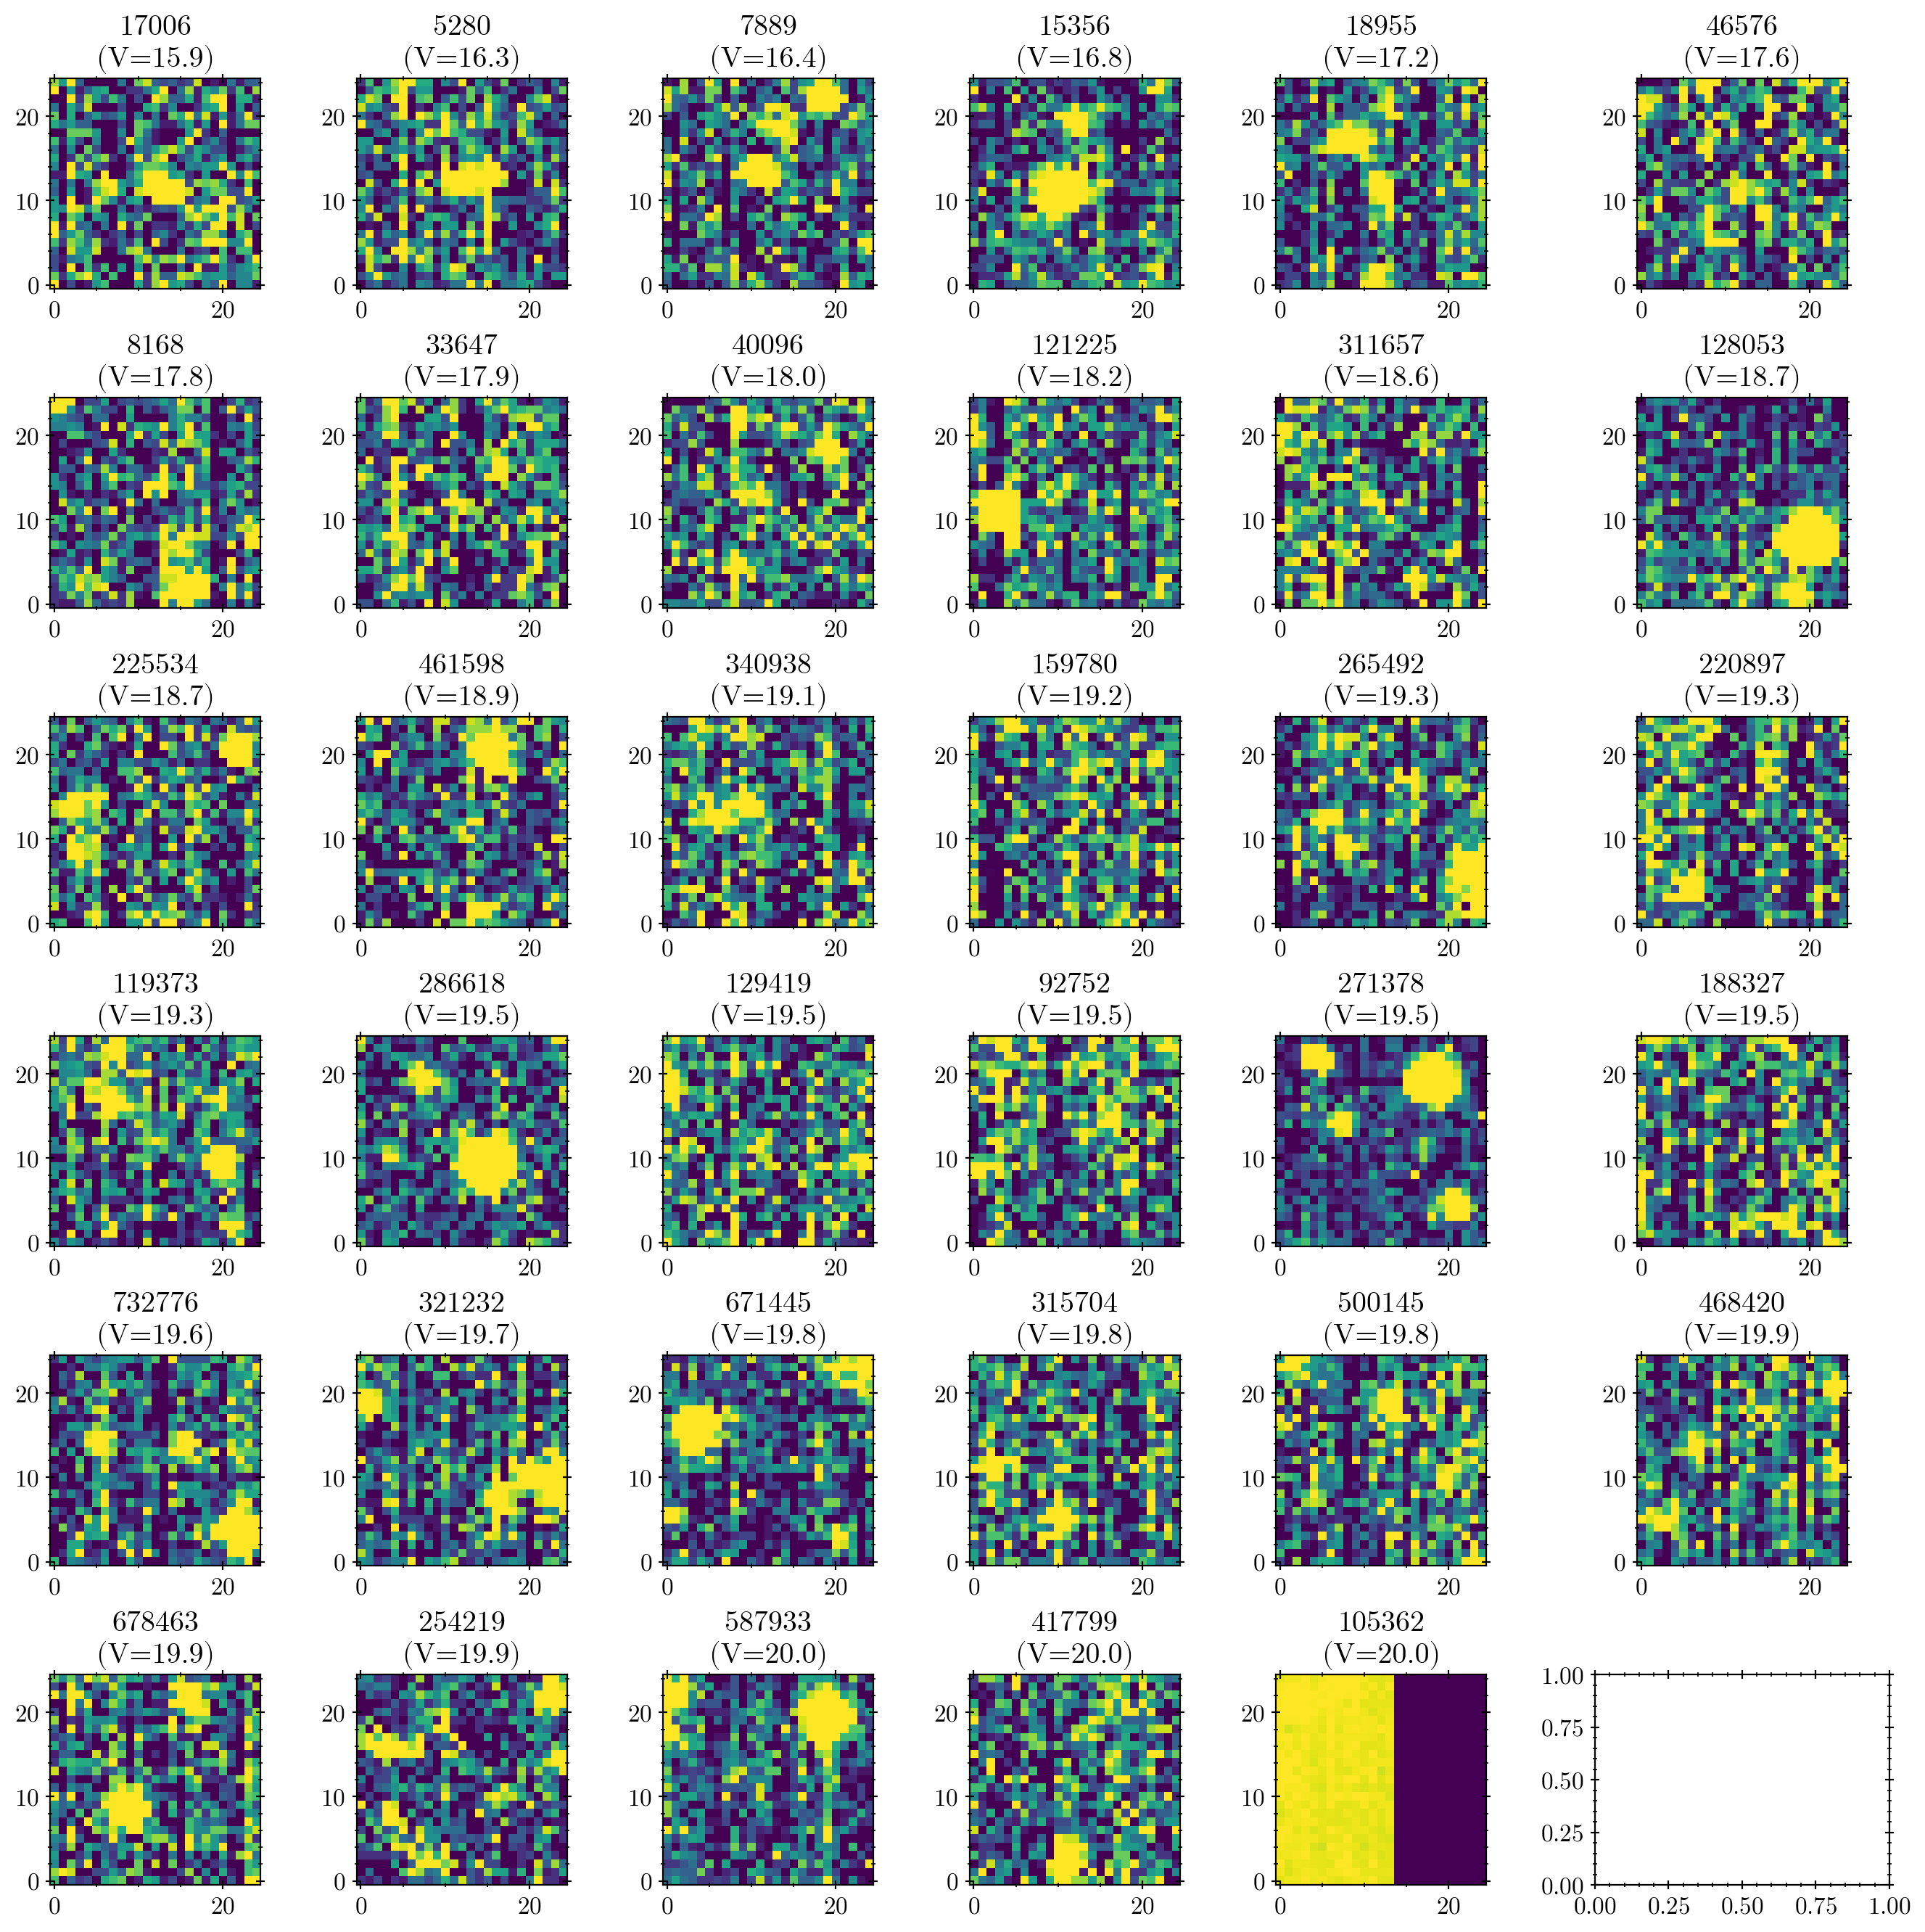

In [ ]:
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
from astropy.nddata import Cutout2D


%config InlineBackend.figure_format = 'retina'
# %matplotlib notebook
InteractiveShell.ast_node_interactivity = 'last_expr'

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': False, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

testid = fitspaths[0].stem
xypos, infov = sloc.all_world2pix_infov(wcss[testid], eph[["ra", "dec"]], 0)
eph["x"] = xypos[:, 0]
eph["y"] = xypos[:, 1]
eph["infov"] = infov

nobj = np.sum(infov)

nrow = 6
ncol = nobj // 6 + 1 if nobj % 6 else nobj // 6

fig, axs = plt.subplots(nrow, ncol, figsize=(2.2*ncol, 2.2*nrow), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)


for i, row in eph.iterrows():
    if not row["infov"]:
        continue
    cut = Cutout2D(
        hdus[testid].data,
        (row["x"], row["y"]),
        size=(25, 25),
        mode='partial',
        fill_value=10
    )
    ax = axs[i//6, i % 6]
    ax.imshow(
        cut.data,
        origin='lower',
        vmin=np.percentile(cut.data, 20),
        vmax=np.percentile(cut.data, 90)
    )
    ax.set(
        title=f"{row['desig']}\n(V={row['vmag']:.1f})",
    )

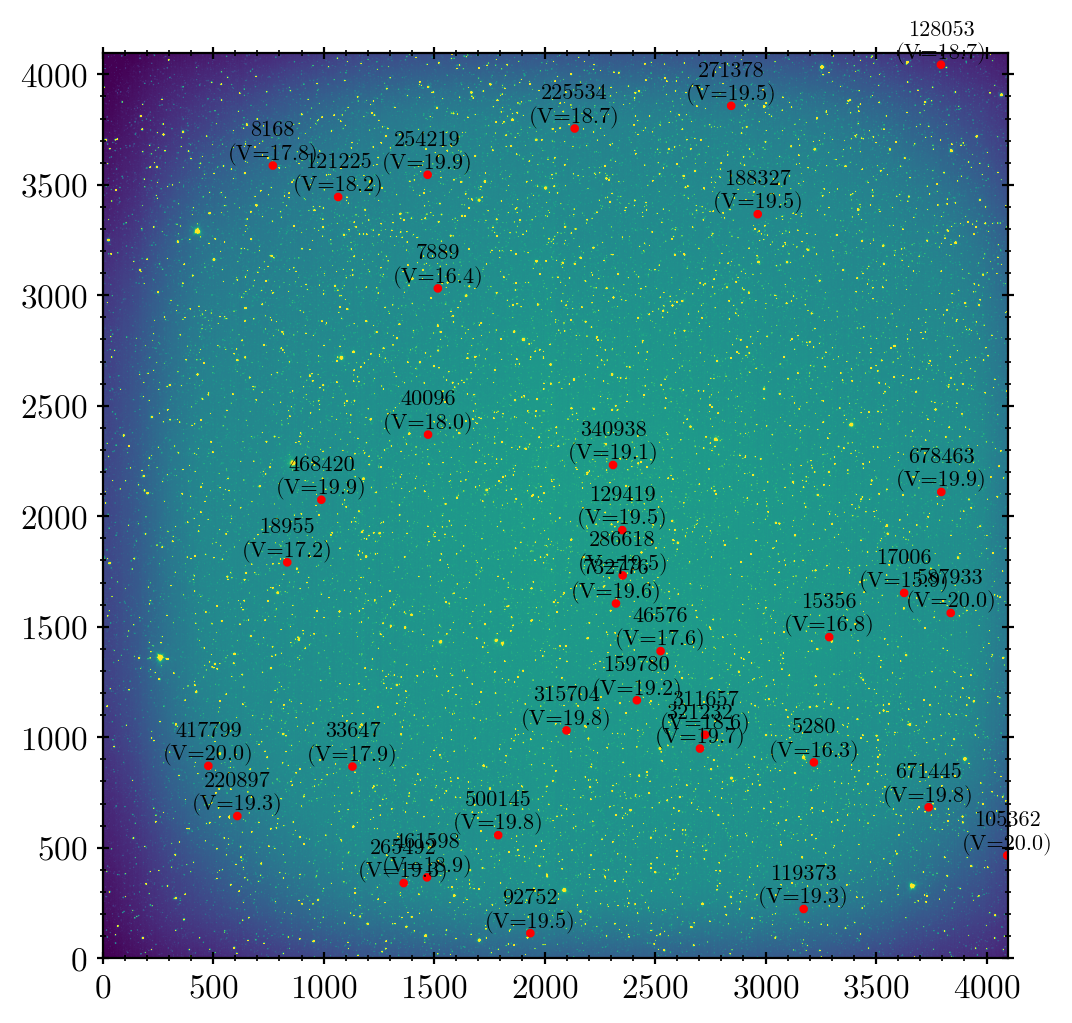

In [19]:
from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
from photutils.aperture import CircularAperture

def znorm(image, stretch=LinearStretch(), **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs), stretch=stretch)


def zimshow(ax, image, stretch=LinearStretch(), cmap=None, **kwargs):
    return ax.imshow(image, norm=znorm(image, stretch=stretch, **kwargs), origin='lower', cmap=cmap)


fig, axs = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

zimshow(axs, hdus[testid].data, stretch=LinearStretch())

aps = CircularAperture(eph[["x", "y"]], r=10)
aps.plot(axs, color='r', lw=1.5)
for i, row in eph.iterrows():
    if not row["infov"]:
        continue
    axs.text(
        row["x"],
        row["y"],
        f"{row['desig']}\n(V={row['vmag']:.1f})",
        color='k',
        fontsize=8,
        ha='center',
        va='bottom'
    )

plt.show();